In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-subsribe/Logistic_Regression_data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [3]:
data = pd.read_csv('../input/customer-subsribe/Logistic_Regression_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   job             9261 non-null   object 
 1   marital         9261 non-null   object 
 2   education       9261 non-null   object 
 3   loan            9261 non-null   object 
 4   age             9261 non-null   int64  
 5   cons_price_idx  9257 non-null   float64
 6   subscribe       9261 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 506.6+ KB


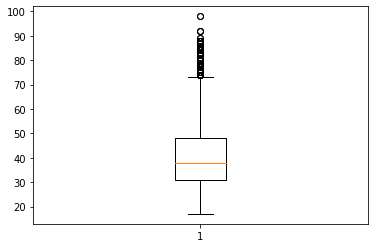

In [4]:
## Outlier check in age variables
# Box Plot
plt.boxplot(data['age'])
plt.show()

In [5]:
## Outlier treatment with Z Score
threshold = 3
outlier = []
for i in data['age']:
    z = (i-data['age'].mean())/data['age'].std()
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)
print('minimum of the outlier list', min(outlier))
## calculate the median for the column excluding the outlier
med = data.loc[data['age']<= min(outlier), 'age'].median()
print('Median of the column excluding outliers-->',med)
f = lambda x: med if x>= min(outlier) else x
data['out_treated_age'] = data['age'].map(f)
max(data['out_treated_age'])
data.drop(['age'], axis=1,inplace = True)

outlier in dataset is [86, 78, 81, 88, 83, 78, 77, 78, 87, 77, 83, 86, 85, 85, 77, 86, 82, 80, 80, 77, 83, 85, 80, 79, 84, 83, 86, 78, 77, 78, 92, 78, 80, 82, 88, 81, 88, 82, 88, 83, 78, 82, 86, 77, 80, 83, 77, 78, 81, 78, 80, 81, 80, 89, 83, 80, 80, 77, 80, 84, 98, 85, 98, 85, 85, 78, 81, 82, 78, 77, 82, 80, 82, 79, 80, 81, 78, 81, 80, 79, 88, 92, 88, 88, 82, 77, 85, 83, 80, 81, 82, 83, 77, 82, 80, 79, 79, 85, 85, 89, 80, 77, 79, 78, 80, 80, 88, 82, 81, 82, 84, 77, 78, 88, 88, 79, 80, 80, 92]
minimum of the outlier list 77
Median of the column excluding outliers--> 37.0


In [6]:
## Check for missing values
data.isna().sum()

job                0
marital            0
education          0
loan               0
cons_price_idx     4
subscribe          0
out_treated_age    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9257 entries, 0 to 9260
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job              9257 non-null   object 
 1   marital          9257 non-null   object 
 2   education        9257 non-null   object 
 3   loan             9257 non-null   object 
 4   cons_price_idx   9257 non-null   float64
 5   subscribe        9257 non-null   int64  
 6   out_treated_age  9257 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 578.6+ KB


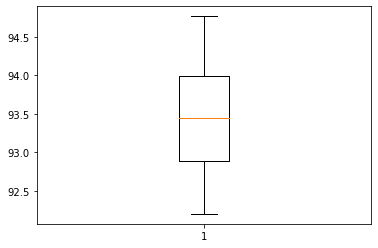

In [7]:
## We can see that there are missing values in cons_price_idx column
## Box plot is not possible with missing values, so lets subset the data except missing value, treat outliers if any,
## Then come back and treat the missing value
filtered_data = data.dropna()
filtered_data.info()
plt.boxplot(filtered_data['cons_price_idx'])
plt.show()
## There is no outlier, so we can continue treating missing values

In [8]:
## fill missing values with mean
data['cons_price_idx'] = data['cons_price_idx'].fillna(data['cons_price_idx'].mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job              9261 non-null   object 
 1   marital          9261 non-null   object 
 2   education        9261 non-null   object 
 3   loan             9261 non-null   object 
 4   cons_price_idx   9261 non-null   float64
 5   subscribe        9261 non-null   int64  
 6   out_treated_age  9261 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 506.6+ KB


In [9]:
scaler = MinMaxScaler()
numerical = data.select_dtypes(exclude=['object'])
data[numerical.columns] = scaler.fit_transform(numerical)
data = pd.get_dummies(data,drop_first = True)

In [10]:
y = data['subscribe']
X = data.drop(['subscribe'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
train_data = pd.concat([X_train,y_train], axis = 1)
test_data = pd.concat([X_test,y_test], axis = 1)

In [11]:
import statsmodels.api as sm
formula = 'subscribe ~ out_treated_age + cons_price_idx + job_retired + job_self_employed + job_unemployed + job_white_collar + \
            marital_married + marital_single +  loan_yes +  education_school '
log_reg = statsmodels.formula.api.logit(formula,data = train_data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.487461
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              subscribe   No. Observations:                 7408
Model:                          Logit   Df Residuals:                     7397
Method:                           MLE   Df Model:                           10
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:                  0.2967
Time:                        02:58:36   Log-Likelihood:                -3611.1
converged:                       True   LL-Null:                       -5134.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8490      0.149     19.131      0.000       2.557       3.141
out_treated_age      -0.3609      0.197     -1.833      0.067      -0.747       0.025
cons_price_idx       -6.1940      0.148    -41.763      0.000      -6.485      -5.903
job_retired           2.0631      0.153     13.492      0.000       1.763       2.363
job_self_employed    -0.0955      0.121     -0.791      0.429      -0.332       0.141
job_unemployed        1.5004      0.132     11.358      0.000       1.242       1.759
job_white_collar      0.3149      0.065      4.877      0.000       0.188       0.441
marital_married      -0.0950      0.096     -0.988      0.323      -0.283       0.093
marital_single        0.3632      0.108      3.363      0.001       0.152       0.575
loan_yes              0.0129      0.083      0.156      0.876      -0.149       0.175
education_school     -0.0665      0.060     -1.101      0.271      -0.185       0.052
=====================================================================================
"""

In [12]:
formula = 'subscribe ~ out_treated_age + cons_price_idx + job_retired + job_self_employed + job_unemployed +\
            job_white_collar + marital_married + marital_single + loan_yes + education_school'
log_reg = statsmodels.formula.api.logit(formula,data = train_data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.487461
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              subscribe   No. Observations:                 7408
Model:                          Logit   Df Residuals:                     7397
Method:                           MLE   Df Model:                           10
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:                  0.2967
Time:                        02:58:37   Log-Likelihood:                -3611.1
converged:                       True   LL-Null:                       -5134.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8490      0.149     19.131      0.000       2.557       3.141
out_treated_age      -0.3609      0.197     -1.833      0.067      -0.747       0.025
cons_price_idx       -6.1940      0.148    -41.763      0.000      -6.485      -5.903
job_retired           2.0631      0.153     13.492      0.000       1.763       2.363
job_self_employed    -0.0955      0.121     -0.791      0.429      -0.332       0.141
job_unemployed        1.5004      0.132     11.358      0.000       1.242       1.759
job_white_collar      0.3149      0.065      4.877      0.000       0.188       0.441
marital_married      -0.0950      0.096     -0.988      0.323      -0.283       0.093
marital_single        0.3632      0.108      3.363      0.001       0.152       0.575
loan_yes              0.0129      0.083      0.156      0.876      -0.149       0.175
education_school     -0.0665      0.060     -1.101      0.271      -0.185       0.052
=====================================================================================
"""

In [13]:
formula = 'subscribe ~ cons_price_idx + job_retired + job_unemployed + job_white_collar + marital_single'
log_reg = statsmodels.formula.api.logit(formula,data = train_data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.487873
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              subscribe   No. Observations:                 7408
Model:                          Logit   Df Residuals:                     7402
Method:                           MLE   Df Model:                            5
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:                  0.2961
Time:                        02:58:37   Log-Likelihood:                -3614.2
converged:                       True   LL-Null:                       -5134.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5790      0.083     30.947      0.000       2.416       2.742
cons_price_idx      -6.1981      0.148    -41.854      0.000      -6.488      -5.908
job_retired          1.9761      0.142     13.915      0.000       1.698       2.254
job_unemployed       1.5160      0.130     11.668      0.000       1.261       1.771
job_white_collar     0.3314      0.062      5.365      0.000       0.210       0.452
marital_single       0.5022      0.064      7.799      0.000       0.376       0.628
====================================================================================
"""

In [14]:
pred_test = log_reg.predict(X_test)
test_data['test_pred_class'] = [1 if x >= 0.5 else 0 for x in pred_test]
pred_train = log_reg.predict(X_train)
train_data['train_pred_class'] = [1 if x >= 0.5 else 0 for x in pred_train]

In [15]:
test_data_cm = confusion_matrix(test_data['subscribe'], test_data['test_pred_class'])
train_data_cm = confusion_matrix(train_data['subscribe'], train_data['train_pred_class'])
print('Train Data Confusion Matrix--> \n',train_data_cm )
print('Test Data Confusion Matrix--> \n',test_data_cm )

Train Data Confusion Matrix--> 
 [[2890  837]
 [ 745 2936]]
Test Data Confusion Matrix--> 
 [[721 180]
 [189 763]]


In [16]:
## Train and test accuracy report

print('Train Data Accuracy Report--> \n',classification_report(train_data['subscribe'], train_data['train_pred_class']))
print('Test Data Accuracy Report--> \n',classification_report(test_data['subscribe'], test_data['test_pred_class']))

Train Data Accuracy Report--> 
               precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      3727
         1.0       0.78      0.80      0.79      3681

    accuracy                           0.79      7408
   macro avg       0.79      0.79      0.79      7408
weighted avg       0.79      0.79      0.79      7408

Test Data Accuracy Report--> 
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.80       901
         1.0       0.81      0.80      0.81       952

    accuracy                           0.80      1853
   macro avg       0.80      0.80      0.80      1853
weighted avg       0.80      0.80      0.80      1853



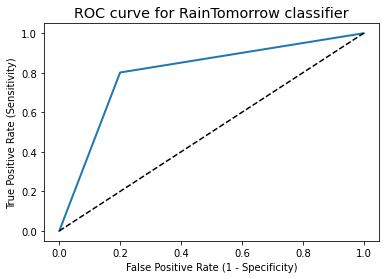

In [17]:
# plot ROC Curve


fpr, tpr, thresholds = roc_curve(test_data['subscribe'], test_data['test_pred_class'], pos_label = 1)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for RainTomorrow classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()